# Fitting Signal Detection Measures to ROC Curves

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import minimize
from sklearn.utils import check_consistent_length
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
np.seterr(all='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Main Functions
[1] Robert R. Sokal and F. James Rohlf. Biometry: The Principles and Practices of Statistics in BiologicalResearch. W.H. Freeman, 3 edition, 1994  
[2] Hoey, J. (2012). The Two-Way Likelihood Ratio (G) Test and Comparison to Two-Way Chi Squared Test.

In [2]:
def compute_dprime(tp, fp):
    # untested
    return stats.norm.ppf(tp) - stats.norm.ppf(fp)

def compute_c_bias(tp, fp):
    # untested
    return - 0.5 * (stats.norm.ppf(tp) + stats.norm.ppf(fp))

def accumulate(*arrays):
    # untested
    out = []
    for a in arrays:
        accumulated = np.cumsum(a)
        out.append(accumulated)
    return out

def to_freq(*arrays):
    # untested
    out = []
    for a in arrays:
        converted = np.array([(x + i / len(a)) / (max(a)+1) for i, x in enumerate(a, start=1)])
        out.append(converted)
    return out

def convert_to_roc(a, b):
    # untested
    a_c, b_c = accumulate(a, b)
    a_f, b_f = to_freq(a_c, b_c)
    return a_f, b_f

def threshold_model_expectation(R, noise_frequency):
    # untested
    # Get the expected values for signals and noises
    expected_signal = ((1 - R) * noise_frequency + R)[:-1]
    expected_noise = noise_frequency[:-1]
    return expected_signal, expected_noise

def signal_detection_model_expectation(d, c):
    # untested
    expected_signal = stats.norm.cdf(d / 2 - c)
    expected_noise = stats.norm.cdf(-d / 2 - c)
    return expected_signal, expected_noise

def dual_process_model_expectation(R, d, c):
    # untested
    expected_signal = R + (1 - R) * stats.norm.cdf(d / 2 - c)
    expected_noise = stats.norm.cdf(-d / 2 - c)
    return expected_signal, expected_noise

def g_test(x, x_freq, expected, x_max):
    # untested
    # Refs: [1, 2]
    # Two-way log-likelihood G-test
    # Implementation issues:
    #    depending on minimization starting variables, the log expressions can throw errors from negative values and div/0 etc. Numpy just warns and continues.
    a = 2 * x * np.log(x_freq / expected) 
    b = 2 * (x_max - x) * np.log((1 - x_freq) / (1 - expected))
    return a + b

def detection_model(parameters, labels, signal, noise, model='sdt', optimizing=False):
    # untested
    # model options: 'threshold', 'sdt', 'dpsdt', 'thresh'
    
    # Implementation issues:
    #    parameters and labels are specified as separate ndarrays arrays because of how the optimizer works. Maybe this can be improved?
    
    #------------------------- Check Inputs ---------------------------#
    # Ensure equal length
    check_consistent_length(signal, noise)
    check_consistent_length(parameters, labels)
    #------------------------------------------------------------------#
    
    #---Cumulate and make ROC frequency data --------------------------#
    # Accumulate (c) the signal and noise data
    signal_c, noise_c = accumulate(signal, noise) # np.cumsum(signal), np.cumsum(noise)
    # Get frequencies for the cumulative signal and noise
    signal_f, noise_f = to_freq(signal_c, noise_c)
    #------------------------------------------------------------------#
    
    #------------------------- Model Specific -------------------------#
    # Figure out which model to compute the expected signal parameters for
    if model == 'sdt':
        if 'd' not in labels:
            raise ValueError(f"Either or both of `R` and `d` not specified in parameter labels. labels specified were: {labels}.")
        d = parameters[labels == 'd'].item()
        c = parameters[(labels!='R') & (labels!='d')] # Can c_values be 0? what about 1?
        exp_signal, exp_noise = signal_detection_model_expectation(d, c)
        
    elif model == 'dpsdt':
        if ('R' not in labels) or ('d' not in labels):
            raise ValueError(f"`R` not specified in parameter labels. labels specified were: {labels}.")
        # Grab the R and d values
        R = parameters[labels == 'R'].item()
        d = parameters[labels == 'd'].item()
    
        c = parameters[(labels!='R') & (labels!='d')] # Can c_values be 0? what about 1?
        # Get the expected values for signals and noises
        exp_signal, exp_noise = dual_process_model_expectation(R, d, c)
    
    elif model == 'thresh':
        if ('R' not in labels):
            raise ValueError(f"`R`not specified in parameter labels. labels specified were: {labels}.")
        R = parameters[labels == 'R'].item()
        exp_signal, exp_noise = threshold_model_expectation(R, noise_f)
    #------------------------------------------------------------------#

    #------------------------- Log Likelihood Function -------------------------#
    # Compute the gsquared using the dual process model parameters
    #   Still getting runtime warnings about division. Function only works with numpy, so can't use math.
    signal_gsquared = g_test(x=signal_c[:-1], x_freq=signal_f[:-1], expected=exp_signal, x_max=signal_c.max())
    noise_gsquared = g_test(x=noise_c[:-1], x_freq=noise_f[:-1], expected=exp_noise, x_max=noise_c.max())
    
    g_squared_summed = np.sum([signal_gsquared, noise_gsquared])
    #------------------------------------------------------------------#

    if optimizing:
        return g_squared_summed
    else:
        return g_squared_summed, exp_signal, exp_noise


def optimize_model(objective, labels, signal, noise, model, iterations=1e2):

    for i in range(1, int(iterations+1)):    
        if i==1:
            parameters = np.zeros(len(labels)) # if other testing is shit then might need to rethink this
            parameters[labels == 'R'] = 0.99 # Make sure R has a good starting value (if it exists)
        else:
            parameters[labels!='R'] = np.random.random_sample(len(parameters[labels!='R']))

#         print(f"Starting parameters:\n\t\t{parameters}")
        optimizing = True # requires True to suppress multiple return values from the objective function

        opt = minimize(fun=objective, x0=parameters, args=(labels, signal, noise, model, optimizing), tol=1e-4)
        
        if opt.success:
            break
    
    status = "successful" if opt.success else "fail"
    print(f"{model} optimization {status} over {i} iterations")
    print(f"{status} starting parameters:{parameters})\n")
    
    return opt

def get_threshold_line(R):
    y, x =  threshold_model_expectation(R, [0, 1, np.nan])
    return x, y

def get_sdt_curve(d):
    c = np.arange(-5, 5, 0.01)+1
    y, x = signal_detection_model_expectation(d, c)
    return x, y

def get_dpsdt_curve(R, d):
    c = np.arange(-5, 5, 0.01)+1
    y, x = dual_process_model_expectation(R, d, c)
    return x, y

In [3]:
tlab = np.array(['R', 'c1', 'c2', 'c3'])
test = np.array([0.99, 0,0,0])
print(f"First: {test}")
test[tlab!='R'] = np.random.random_sample(len(test[tlab!='R']))
print(f"Second:{test}")

First: [0.99 0.   0.   0.  ]
Second:[0.99       0.49706037 0.70578931 0.13546678]


## Testing the different models with example data

#### Testing example data setup

In [4]:
# # Example data 1
# signal = [508,224,172,135,119,63] # Signal present examples
# noise = [102,161,288,472,492,308] # Signal absent examples

# # Example data 2
example_2 = {'signal':[431,218,211, 167,119, 69], 'noise':[102,161,288,472,492,308],
             'thresh_parameters': np.array([0.459564977806581]),# R
             'thresh_labels': np.array(['R']),
             'thresh_testing_G': 198.940934458771,
             
             'sdt_parameters':np.array([1.01439006038876, # d
                                        0.958740557949141,
                                        0.48797217624754,
                                        -0.00935955993937299,
                                        -0.614403917274333,
                                        -1.37492636400985]),
             'sdt_labels':np.array(['d', 'c1', 'c2', 'c3', 'c4', 'c5']),
             'sdt_testing_G': 58.6027491579573,
             
             'dpsdt_parameters':np.array([0.240020821540452, # R
                                          0.691305735458908, # d
                                          1.28497655282868,
                                          0.687197522357083,
                                          0.134196177689579,
                                          -0.495119831811334,
                                          -1.25674378226952]),
             'dpsdt_labels':np.array(['R', 'd', 'c1', 'c2', 'c3', 'c4', 'c5']),
             'dpsdt_testing_G': 17.4073551151917}



# Example data 3 -----------------------------------------------------#
signal = [13,10,12,11,9,1] # Signal present examples
noise = [4,4,22,35,15,4] # Signal absent examples
example_3 = {'signal':[13,10,12,11,9,1], 'noise':[4,4,22,35,15,4],
             'thresh_parameters': np.array([0.290197112447361]),
             'thresh_labels': np.array(['R']),
             'thresh_testing_G':5.097716096,
             'sdt_parameters':np.array([0.688841386383297, 
                                        1.17690699236133,
                                        0.753893701189727,
                                        0.0233356921180415,
                                        -0.91519735628651,
                                        -1.95591806972918]),
             'sdt_labels':np.array(['d', 'c1', 'c2', 'c3', 'c4', 'c5']),
             'sdt_testing_G':7.70924692362448,
             'dpsdt_parameters':np.array([0.223677389183856,
                                          0.262320983747282,
                                          1.61202361145935,
                                          1.08632760356576,
                                          0.190627724971991,
                                          -0.794393708266734,
                                          -1.81546835049758]),
             'dpsdt_labels':np.array(['R', 'd', 'c1', 'c2', 'c3', 'c4', 'c5']),
            'dpsdt_testing_G':3.05123502713937}

#### Testing G$^2$ against `ROC.xlsx` results 

In [5]:
model = 'thresh'
example = example_2

# Testing -----------------
signal = example['signal']
noise = example['noise']

labels = example[f'{model}_labels']
parameters = example[f'{model}_parameters']
testing_g = example[f'{model}_testing_G']

print(f"Testing the {model} model:\n")
print(f"Labels: {labels}")
print(f"Parameters:{parameters}\n")

# Get ROC data and print it to make sure it's right
s, n = convert_to_roc(signal, noise)
print(f"\tSignal: {s}\n\tNoise: {n}\n")

g, exp_s, exp_n = detection_model(parameters=parameters, labels=labels,
               signal=signal, noise=noise, model=model)
print(f"\tSum G\N{SUPERSCRIPT TWO} = {g} (testing G\N{SUPERSCRIPT TWO} = {testing_g})\n\tExpected signal:{exp_s}\n\tExpected noise:{exp_n}")

Testing the thresh model:

Labels: ['R']
Parameters:[0.45956498]

	Signal: [0.35457785 0.53399123 0.70764803 0.84512061 0.94311952 1.        ]
	Noise: [0.05601243 0.14437135 0.30235746 0.56122076 0.83104898 1.        ]

	Sum G² = 198.9409344587715 (testing G² = 198.940934458771)
	Expected signal:[0.48983605 0.53758831 0.62296954 0.76286833 0.90869295]
	Expected noise:[0.05601243 0.14437135 0.30235746 0.56122076 0.83104898]


#### Testing minimization against Excel's GRG nonlinear (from `ROC.xlsx` file)

In [6]:
model = 'dpsdt'
example = example_2

# Testing -----------------
signal = example['signal']
noise = example['noise']

labels = example[f'{model}_labels']
# parameters = example[f'{model}_parameters'] # <--- solving for these
testing_g = example[f'{model}_testing_G'] # <-- by minimimzing this

print(f"Testing the {model} model:\n")
print(f"Labels: {labels}")


# Get ROC data and print it to make sure it's right
s, n = convert_to_roc(signal, noise)
print(f"\tSignal: {s}\n\tNoise: {n}\n")


# -------- Minimization -------------------------------------------------------#
opt = optimize_model(objective=detection_model,
                     labels=labels,
                     signal=signal,
                     noise=noise,
                     model=model)
print(opt)
print()

opt_parameters = opt.x
g, exp_s, exl_noise = detection_model(parameters=opt_parameters, labels=labels,
               signal=signal, noise=noise, model=model)
print(f"\tSum G\N{SUPERSCRIPT TWO} = {g} (testing G\N{SUPERSCRIPT TWO} = {testing_g})\n\tExpected signal:{exp_s}\n\tExpected noise:{exp_n}")

Testing the dpsdt model:

Labels: ['R' 'd' 'c1' 'c2' 'c3' 'c4' 'c5']
	Signal: [0.35457785 0.53399123 0.70764803 0.84512061 0.94311952 1.        ]
	Noise: [0.05601243 0.14437135 0.30235746 0.56122076 0.83104898 1.        ]

dpsdt optimization successful over 2 iterations
successful starting parameters:[0.99       0.13901861 0.28892476 0.28260432 0.19074246 0.79243589
 0.23529353])

      fun: 17.40735508454174
 hess_inv: array([[ 0.00037285, -0.00063008,  0.00057709,  0.00040249,  0.00028901,
         0.00024469,  0.00023203],
       [-0.00063008,  0.00146757, -0.00103695, -0.00074139, -0.00056149,
        -0.0005054 , -0.00050773],
       [ 0.00057709, -0.00103695,  0.00166171,  0.00063617,  0.00045573,
         0.00039338,  0.00038228],
       [ 0.00040249, -0.00074139,  0.00063617,  0.00086479,  0.00032647,
         0.00027439,  0.000266  ],
       [ 0.00028901, -0.00056149,  0.00045573,  0.00032647,  0.00053013,
         0.00021596,  0.0002213 ],
       [ 0.00024469, -0.0005054 ,  0

thresh optimization successful over 1 iterations
successful starting parameters:[0.99])

sdt optimization successful over 2 iterations
successful starting parameters:[0.35526721 0.84663326 0.51233864 0.35698402 0.37634605 0.6126533 ])

dpsdt optimization successful over 2 iterations
successful starting parameters:[0.99       0.692418   0.63245143 0.20306278 0.03328965 0.36314213
 0.03075972])



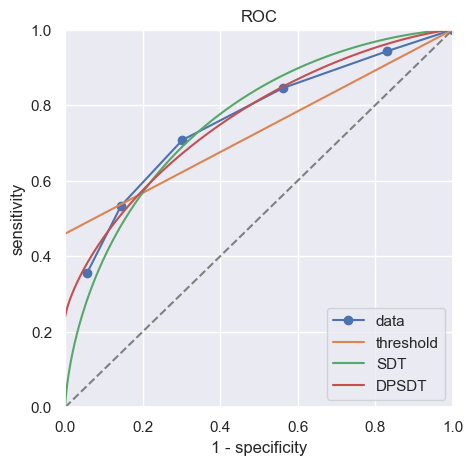

In [7]:
example = example_2
thresh_opt = optimize_model(objective=detection_model,
                            labels=example['thresh_labels'],
                            signal=signal,
                            noise=noise,
                            model='thresh')
sdt_opt = optimize_model(objective=detection_model,
                         labels=example['sdt_labels'],
                         signal=signal,
                         noise=noise,
                         model='sdt')
dpsdt_opt = optimize_model(objective=detection_model,
                           labels=example['dpsdt_labels'],
                           signal=signal,
                           noise=noise,
                           model='dpsdt')


# Get ROC data and print it to make sure it's right
data_x, data_y = convert_to_roc(noise, signal)
thresh_x, thresh_y = get_threshold_line(R=thresh_opt.x)
sdt_x, sdt_y = get_sdt_curve(d=sdt_opt.x[0])
dpsdt_x, dpsdt_y = get_dpsdt_curve(R=dpsdt_opt.x[0], d=dpsdt_opt.x[1])


fig, ax = plt.subplots(figsize=(5,5), dpi=100)
ax.plot([0,1], [0,1], c='grey', ls='dashed')
ax.plot(data_x, data_y, marker='o', label='data')
ax.plot(thresh_x,thresh_y, label='threshold')
ax.plot(sdt_x, sdt_y, label='SDT')
ax.plot(dpsdt_x, dpsdt_y, label='DPSDT')
ax.set_ylim(0,1); ax.set_xlim(0,1)
ax.set_xlabel('1 - specificity'); ax.set_ylabel('sensitivity')
ax.legend(loc = 'lower right')

ax.set_title('ROC')
plt.show()